#### Imports

In [64]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current CUDA device
    device = torch.cuda.current_device()

    # Get the GPU memory stats
    allocated_memory = torch.cuda.memory_allocated(device=device)
    max_allocated_memory = torch.cuda.max_memory_allocated(device=device)

    # Convert bytes to GB
    allocated_memory_gb = allocated_memory / 1e9
    max_allocated_memory_gb = max_allocated_memory / 1e9

    # Print the GPU memory stats
    print(f"Currently allocated GPU memory: {allocated_memory_gb:.2f} GB")
    print(f"Max allocated GPU memory: {max_allocated_memory_gb:.2f} GB")
else:
    print("CUDA is not available.")

Currently allocated GPU memory: 0.00 GB
Max allocated GPU memory: 0.09 GB


In [2]:
import pandas as pd
from utils import *
from transformers import Trainer, EarlyStoppingCallback, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification

In [3]:
mappings_inverse

{5: 'pants-on-fire',
 0: 'false',
 4: 'barely-true',
 1: 'half-true',
 2: 'mostly-true',
 3: 'true'}

#### Main Workflow

##### Load Data

In [4]:
dataset = load_data(path='liar', remove_all=True, concat=True)

Found cached dataset liar (/root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-b6b43123e7494e92.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-0456a8b8d75ee21c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-cdc998162e96d85d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-7f580f3c1b6060e2.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-600e229870b79f2b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.

In [5]:
dataset['train'][0]

{'label': 0,
 'statement': 'Says the Annies List political group supports third-trimester abortions on ',
 'label_name': 'false',
 'binary_label': 1,
 'trinary_label': 2,
 'text': 'Says the Annies List political group supports third-trimester abortions on  [SEP] abortion [SEP] dwayne-bohac [SEP] a mailer'}

##### Balance Data

In [57]:
def balance_dataset(dataset, split='train', label_type='binary_label'):    
    df = pd.DataFrame(dataset[split])
    grouped_df = df.groupby(label_type)
    min_class = grouped_df.size().min()
    balanced_df = grouped_df.apply(lambda x: x.sample(n=min_class, replace=False)).reset_index(drop=True)
    
    return Dataset.from_pandas(balanced_df)

def display_counts(dataset, split=None, label_type='binary_label'):
    if split:
        sns.countplot(data=pd.DataFrame(dataset[split]), x=label_type, palette=palette)
    else:
        sns.countplot(data=pd.DataFrame(dataset), x=label_type, palette=palette)
        
    plt.title('Label Count')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()


In [52]:
trainset = balance_dataset(dataset, split='train')
testset = dataset['test']
valset = dataset['validation']

##### Explore Data

In [53]:
display_samples(trainset, num_samples=3)

Says under Oregon law, girls from 15 years of age and up are given complete [SEP] health-care,public-health [SEP] cnsnews [SEP] a news article. 0
Says Hillary Clinton defended Syrias President Assad as a possible reformer [SEP] foreign-policy [SEP] chris-wallace [SEP] comments on "Fox News Sunday" 1
Says North Carolina Republican Senate candidate Thom Tillis supports a plan [SEP] federal-budget,health-care,medicare [SEP] patriot-majority-usa [SEP] a campaign ad 4


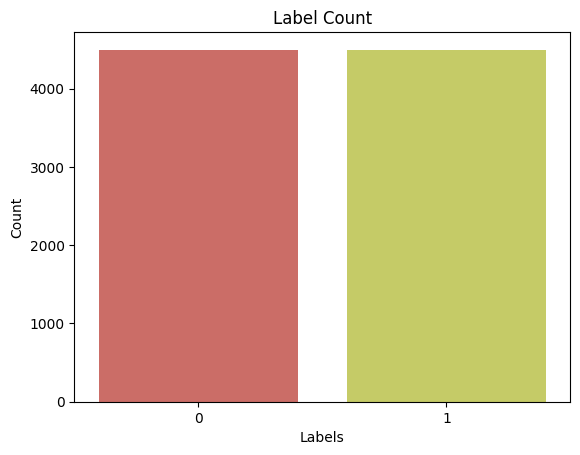

In [61]:
display_counts(trainset, label_type='binary_label')

In [62]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')
def tokenize_dataset(data):
    return tokenizer(data['text'],
                     max_length=100,
                     truncation=True,
                     padding="max_length")

train_dataset = trainset.map(tokenize_dataset)
test_dataset = testset.map(tokenize_dataset)
val_dataset = valset.map(tokenize_dataset)

Map:   0%|          | 0/8994 [00:00<?, ? examples/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-ec2d7735c7b6b778.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-16a37704e2b5a7ba.arrow


In [73]:
train_dataset.__getitem__(0)

{'label': 2,
 'statement': 'Says Rick Perry told students he couldnt attend a gubernatorial forum due t',
 'label_name': 'mostly-true',
 'binary_label': 0,
 'trinary_label': 0,
 'text': 'Says Rick Perry told students he couldnt attend a gubernatorial forum due t [SEP] ethics [SEP] bill-white [SEP] a news story',
 'input_ids': [101,
  8652,
  1116,
  5512,
  6306,
  1500,
  1651,
  1119,
  1577,
  1204,
  4739,
  170,
  21488,
  13912,
  1496,
  189,
  102,
  13438,
  102,
  4550,
  118,
  1653,
  102,
  170,
  2371,
  1642,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

In [74]:
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2).to(torch.device('cuda'))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.b

In [85]:
train_dataset

Dataset({
    features: ['label', 'statement', 'label_name', 'binary_label', 'trinary_label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 8994
})

In [75]:

def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    print(labels)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [78]:
training_args = TrainingArguments(
    output_dir="./sentiment_transfer_learning_transformer/",
    logging_dir='./sentiment_transfer_learning_transformer/logs',
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-4,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
    label_names=['binary_label']
)

In [79]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

TypeError: forward() got an unexpected keyword argument 'binary_label'

In [80]:
def evaluate_performance(trainer, inputs):
    from torch import from_numpy
    
    # basic evaluation of model
    trainer.evaluate(inputs)

    # get label probability prediction
    y_pred = trainer.predict(inputs)
    pred = from_numpy(y_pred.predictions)

    y_proba = softmax(pred)

    # get predicted labels and true labels
    y_true_labels = y_pred.label_ids
    y_pred_labels = np.argmax(y_proba, axis=1)

    for metric in [evaluate.load("f1"), evaluate.load("recall"), evaluate.load("precision")]:
        print(metric.compute(predictions=y_pred_labels, references=y_true_labels, average='macro'))

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    sns.heatmap(cm, annot=True)
    plt.show()

/tmp/ipykernel_3377/562731981.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.047619047619047616}
{'recall': 0.16666666666666666}
{'precision': 0.027777777777777776}


/mnt/c/Users/chris/Desktop/GitHub/Fake-News-Detection/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


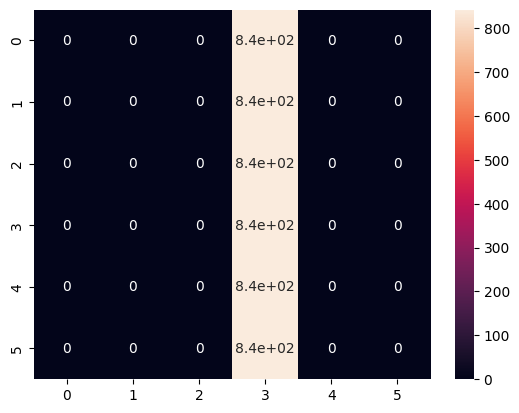

In [ ]:
evaluate_performance(trainer, train_dataset)

/tmp/ipykernel_3377/562731981.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.04707719767960732}
{'recall': 0.16666666666666666}
{'precision': 0.027409716809560922}


/mnt/c/Users/chris/Desktop/GitHub/Fake-News-Detection/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


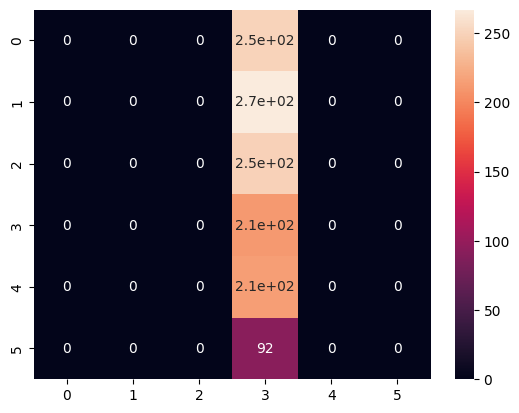

In [ ]:
evaluate_performance(trainer, test_dataset)

/tmp/ipykernel_3377/562731981.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.03877036017435191}
{'recall': 0.16666666666666666}
{'precision': 0.021936656282450673}


/mnt/c/Users/chris/Desktop/GitHub/Fake-News-Detection/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


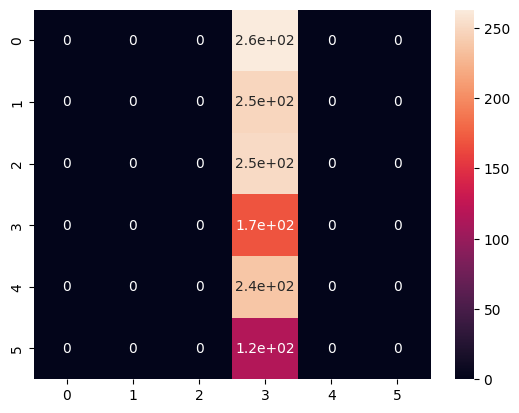

In [ ]:
evaluate_performance(trainer, val_dataset)

In [ ]:
def get_roc_curve(trainer, inputs):
    ids = torch.tensor(inputs['input_ids']).to(device=torch.device('cuda'))
    mask = torch.tensor(inputs['attention_mask']).to(device=torch.device('cuda'))
    y_pred = trainer(input_ids=ids, attention_mask=mask)
    y_proba = softmax(y_pred.predictions)

    y_true_labels = y_pred.label_ids

    fpr, tpr, threshold = roc_curve(y_true_labels, y_proba[:, 1])

    return fpr, tpr, threshold

def plot_roc_curves(model, inputs, label='Train Classifier'):
    fpr, tpr, _ = get_roc_curve(model, inputs)

    plt.figure(figsize=(7, 5))
    plt.title(f'ROC Curve for {label}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.axis([-.05, 1, 0, 1.05])

    plt.plot(fpr, tpr, label=label, color=sns.color_palette('hls')[0])

    plt.legend()
    plt.show()

In [ ]:
plot_roc_curves(model, train_dataset, label = 'Train Classifier')

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.78 GiB (GPU 0; 8.00 GiB total capacity; 20.37 GiB already allocated; 0 bytes free; 20.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plot_roc_curves(model, test_dataset, label = 'Test Classifier')

In [ ]:
plot_roc_curves(model, val_dataset, label = 'Validation Classifier')